In [2]:
import os
import sys
import time
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from time import gmtime

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path.insert(0, '/Users/wassilyminkow/Scripts/Python3/')

from Neuroinformatics.torpor_project.data import *
from Neuroinformatics.math.pandas.statistics import *
from Neuroinformatics.data.pandas.time_series import TimeSeries
from Neuroinformatics.math.curves import *
from Neuroinformatics.math.regression import *

In [4]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

In [5]:
path = "/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L"

In [6]:
paths = {}
for folder in os.walk(path):
    key = folder[0].split(os.path.sep)[-1]
    li = []
    for file in folder[2:][0]:
        if file.split('.')[-1] == "bdf":
            li.append(os.path.join(folder[0], file))
    if len(li) > 0:
        paths[key] = li

In [18]:
for key, value in paths.items():
    print(key, value[1].split('/')[-1][:-10])

RecV3_2_ang+ 31-01-2019
RecV3_3_ang+ 31-01-2019
RecV3_4_ang+ 31-01-2019
RecV3_1_ang- 31-01-2019


In [19]:
min_per_epoch = 1
order = 400 # filter order
a = 1 
bands = np.array([[1, 4], [4, 8]]) 
chans = ["Channel 1", "Channel 2"]
kinds = ["Power",
         "Power {}-{}".format(bands[0,0], bands[0,1]), 
         "Power {}-{}".format(bands[1,0], bands[1,1]),
        ]

data = []
for chan in chans:
    for kind in kinds:
        data.append("{} {}".format(chan, kind))        
data.append("Acceleration")
data.append("Subject")
data.append("Record")

data = pd.DataFrame(columns=data)

start_epoc = 0
counter = 0

for key, value in paths.items():
    for name in value:

        # read EEG and acceleration data
        raw_data = mne.io.read_raw_edf(name)
            
        fs = round(raw_data.info['sfreq'])
        df = pd.DataFrame(raw_data.get_data().T, columns=raw_data.info["ch_names"])        

#         if name == "/Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/01-02-2019_14-21.bdf":
#             df = df.iloc[:, 100000:200000]
        
        # Calculate # of polygraphy epochs and correspotding # of EEG samples for the  EEG file
        n_epocs = int(np.floor(df.shape[0]/fs/SEC_PER_MIN/min_per_epoch))
        n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

        # Skip damaged samples at the ending
        df_epocs = df.iloc[:n_samples, :]

        # Polygraphy epoch length in EEG samples.
        step = fs*SEC_PER_MIN*min_per_epoch

        data_new = {}
        
#         n = 0
        for chan in chans:

            # low-pass filter
            b = firwin(order, bands[0, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_lo = filtfilt(b, a, df_epocs[chan].iloc[:]) # apply filter
            
            # high-pass filter
            b = firwin(order, bands[1, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_hi = filtfilt(b, a, df_epocs[chan].iloc[:])
            
#             n+=1
#             subplot(5,1,n)
#             plot(standardize(df_epocs_hi[1000:15000]), label="{} {}".format(chan, kinds[1]))
#             n+=1
#             subplot(5,1,n)
#             plot(standardize(df_epocs_lo[1000:15000]), label="{} {}".format(chan, kinds[2]))
            
            # band power data
            data_new.update({
                "{} {}".format(chan, kinds[0]): np.array(list(map(lambda i: (df_epocs[chan].iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[1]): np.array(list(map(lambda i: (df_epocs_lo[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[2]): np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
            })
            
            del df_epocs_lo, df_epocs_hi

        acc_sign = df_epocs["STI 014"].diff().fillna(0)    
        
        # acceleration data
        data_new.update({
            "Acceleration": np.array(list(map(lambda i: (acc_sign.iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
                        })
        
        data_new = pd.DataFrame(data_new)
        data_new["Subject"] = key
        data_new["Record"] = name.split('/')[-1][:-10]
        
        data = pd.concat([data, data_new])
        
        start_epoc += n_epocs
        counter += 1
        
data = data.reset_index(drop=True)

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/01-02-2019_14-22.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: Fu

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_2_ang+/31-01-2019_15-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/01-02-2019_14-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_3_ang+/31-01-2019_15-28.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/01-02-2019_14-33.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_4_ang+/31-01-2019_15-43.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/01-02-2019_14-21.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_lactate/1_D-L/RecV3_1_ang-/31-01-2019_15-23.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-19-0226a4a4a604>:28: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


In [8]:
data = pd.read_csv("lactate.csv")

In [20]:
data

,Channel 1 Power,Channel 1 Power 1-4,Channel 1 Power 4-8,Channel 2 Power,Channel 2 Power 1-4,Channel 2 Power 4-8,Acceleration,Subject,Record
0,0.052778,5.699744e-10,3.160907e-10,0.015787,7.367579e-10,5.668753e-10,1018.953600,RecV3_2_ang+,01-02-2019
1,0.053052,5.627204e-10,2.709586e-10,0.015732,7.498979e-10,4.421532e-10,249.270733,RecV3_2_ang+,01-02-2019
2,0.053176,6.521131e-10,4.365111e-10,0.015707,9.892243e-10,8.070392e-10,71.134133,RecV3_2_ang+,01-02-2019
3,0.052996,7.137406e-10,2.857428e-10,0.015643,1.072749e-09,4.327074e-10,58.265133,RecV3_2_ang+,01-02-2019
4,0.052461,4.965823e-10,3.505760e-10,0.015441,5.894226e-10,5.096781e-10,2431.412067,RecV3_2_ang+,01-02-2019
5,0.052397,6.400241e-10,4.100222e-10,0.015573,7.990883e-10,5.178795e-10,1077.991733,RecV3_2_ang+,01-02-2019
6,0.052448,7.147998e-10,3.276418e-10,0.015723,9.247423e-10,3.948650e-10,100.672333,RecV3_2_ang+,01-02-2019
7,0.052396,8.680174e-10,6.323382e-10,0.015658,1.113766e-09,9.107700e-10,97.968933,RecV3_2_ang+,01-02-2019
8,0.052122,7.147329e-10,3.058392e-10,0.015672,8.225040e-10,3.967438e-10,11872.065200,RecV3_2_ang+,01-02-2019
9,0.052404,5.985720e-10,3.942953e-10,0.015808,8.155583e-10,4.993467e-10,8493.218800,RecV3_2_ang+,01-02-2019


In [21]:
data.to_csv("lactate.csv")

In [23]:
data["Record"].unique()

array(['01-02-2019', '31-01-2019'], dtype=object)

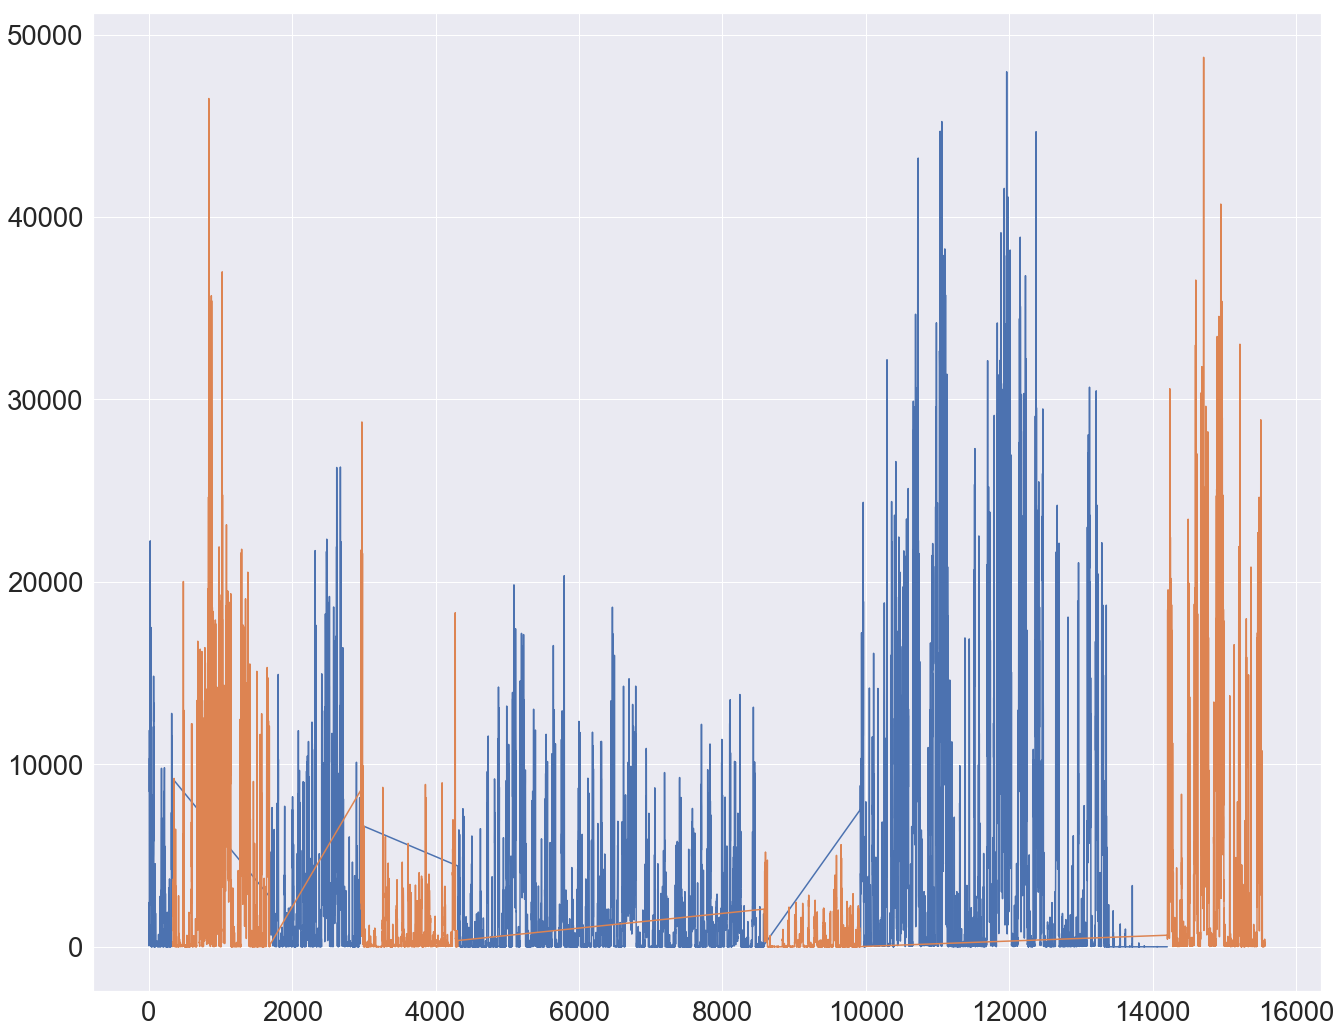

In [24]:
for i in data["Record"].unique():
    data[data["Record"]==i]["Acceleration"].plot()

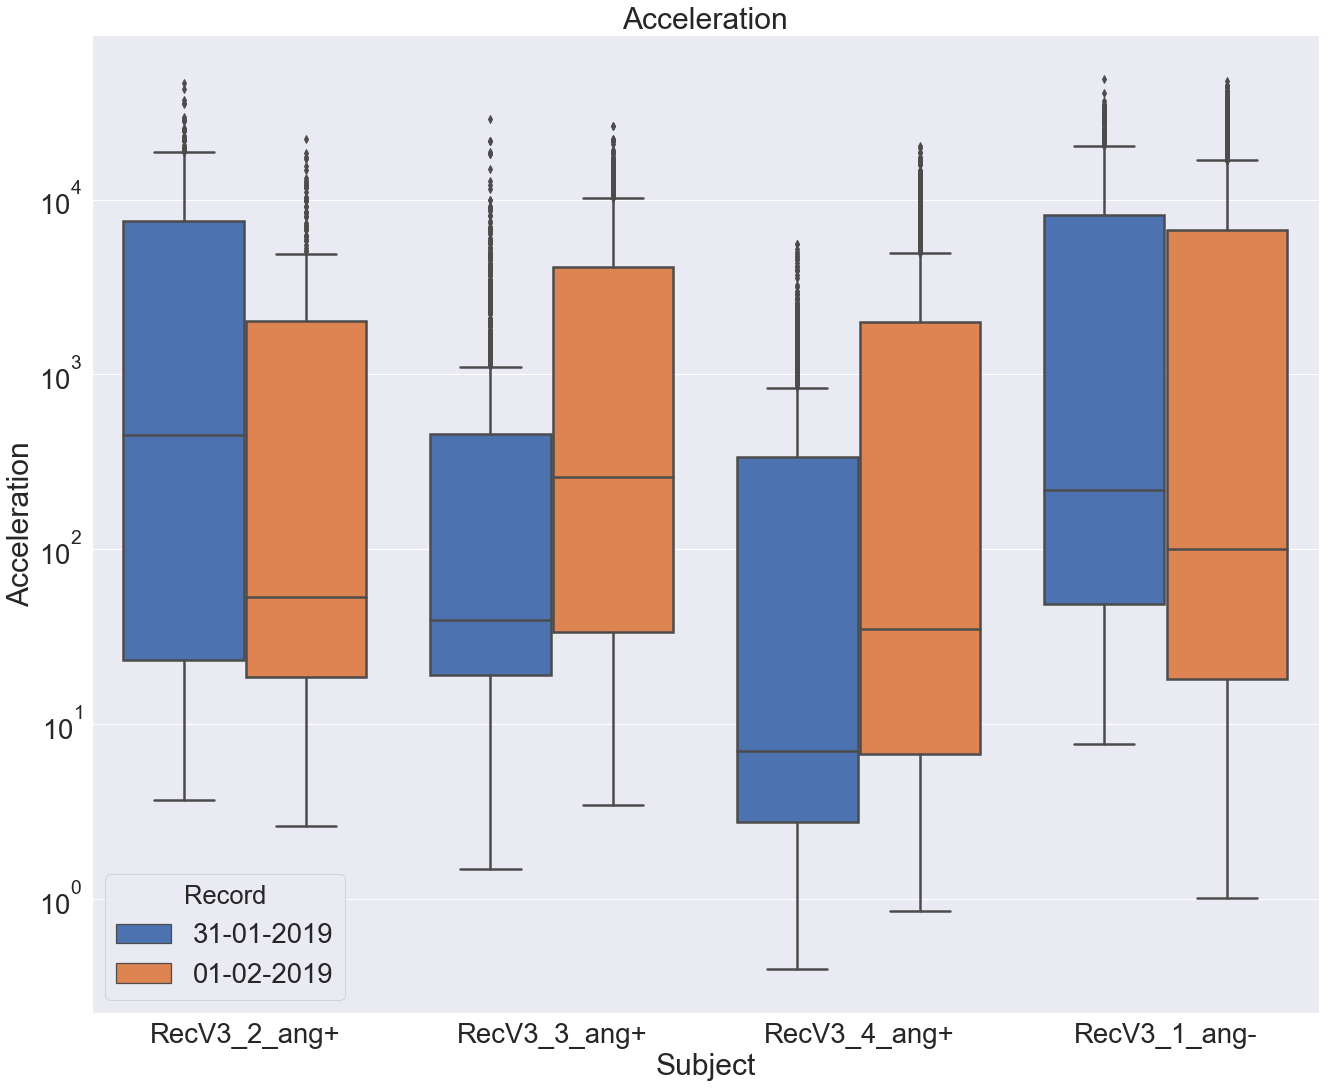

In [120]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="Subject", 
            y="Acceleration", 
            hue="Record",
            hue_order=['31-01-2019', '01-02-2019'],
            linewidth=2.5,
            saturation=1,
            data=data, 
            ax=ax)
title("Acceleration")
show()

In [49]:
wilcoxon(
    data[(data["Subject"]=='RecV3_3_ang+') & (data["Record"]=='31-01-2019')]['Acceleration'].sample(200),
    data[(data["Subject"]=='RecV3_4_ang+') & (data["Record"]=='31-01-2019')]['Acceleration'].sample(200)
)

WilcoxonResult(statistic=6543.0, pvalue=1.876194997344552e-05)

In [46]:
data

,Channel 1 Power,Channel 1 Power 1-4,Channel 1 Power 4-8,Channel 2 Power,Channel 2 Power 1-4,Channel 2 Power 4-8,Acceleration,Subject,Record
0,0.052778,5.699744e-10,3.160907e-10,0.015787,7.367579e-10,5.668753e-10,1018.953600,RecV3_2_ang+,01-02-2019
1,0.053052,5.627204e-10,2.709586e-10,0.015732,7.498979e-10,4.421532e-10,249.270733,RecV3_2_ang+,01-02-2019
2,0.053176,6.521131e-10,4.365111e-10,0.015707,9.892243e-10,8.070392e-10,71.134133,RecV3_2_ang+,01-02-2019
3,0.052996,7.137406e-10,2.857428e-10,0.015643,1.072749e-09,4.327074e-10,58.265133,RecV3_2_ang+,01-02-2019
4,0.052461,4.965823e-10,3.505760e-10,0.015441,5.894226e-10,5.096781e-10,2431.412067,RecV3_2_ang+,01-02-2019
5,0.052397,6.400241e-10,4.100222e-10,0.015573,7.990883e-10,5.178795e-10,1077.991733,RecV3_2_ang+,01-02-2019
6,0.052448,7.147998e-10,3.276418e-10,0.015723,9.247423e-10,3.948650e-10,100.672333,RecV3_2_ang+,01-02-2019
7,0.052396,8.680174e-10,6.323382e-10,0.015658,1.113766e-09,9.107700e-10,97.968933,RecV3_2_ang+,01-02-2019
8,0.052122,7.147329e-10,3.058392e-10,0.015672,8.225040e-10,3.967438e-10,11872.065200,RecV3_2_ang+,01-02-2019
9,0.052404,5.985720e-10,3.942953e-10,0.015808,8.155583e-10,4.993467e-10,8493.218800,RecV3_2_ang+,01-02-2019


In [43]:
data[(data["Subject"]=='RecV3_2_ang+') & (data["Record"]=='31-01-2019')].sample(100)

,Channel 1 Power,Channel 1 Power 1-4,Channel 1 Power 4-8,Channel 2 Power,Channel 2 Power 1-4,Channel 2 Power 4-8,Acceleration,Subject,Record
1472,0.051072,4.019654e-09,1.720552e-09,0.014546,3.577891e-09,1.924133e-09,11.657400,RecV3_2_ang+,31-01-2019
545,0.052841,4.205113e-09,1.679574e-09,0.014159,3.551121e-09,1.975398e-09,261.479800,RecV3_2_ang+,31-01-2019
614,0.056271,5.761684e-10,5.993927e-10,0.013505,6.268002e-10,6.669226e-10,63.634000,RecV3_2_ang+,31-01-2019
652,0.052745,2.144742e-09,1.298763e-09,0.014547,2.135892e-09,1.811756e-09,11.197467,RecV3_2_ang+,31-01-2019
500,0.051927,4.557708e-09,2.060390e-09,0.014682,3.726160e-09,2.661291e-09,8.514933,RecV3_2_ang+,31-01-2019
451,0.053781,1.528206e-09,1.229222e-09,0.014558,1.351642e-09,1.669200e-09,31.863533,RecV3_2_ang+,31-01-2019
346,0.049128,6.862410e-10,4.062876e-10,0.014335,9.433748e-10,8.639267e-10,3146.724533,RecV3_2_ang+,31-01-2019
1677,0.052872,7.973144e-10,4.230140e-10,0.014697,9.767082e-10,6.227066e-10,644.665333,RecV3_2_ang+,31-01-2019
440,0.053921,1.899709e-09,9.298523e-10,0.014594,2.009443e-09,1.315085e-09,12.961133,RecV3_2_ang+,31-01-2019
1208,0.052938,1.571767e-09,1.121735e-09,0.015245,1.680459e-09,1.436438e-09,13.622933,RecV3_2_ang+,31-01-2019


In [35]:
from scipy.stats import wilcoxon

In [ ]:
wilcoxon(d)

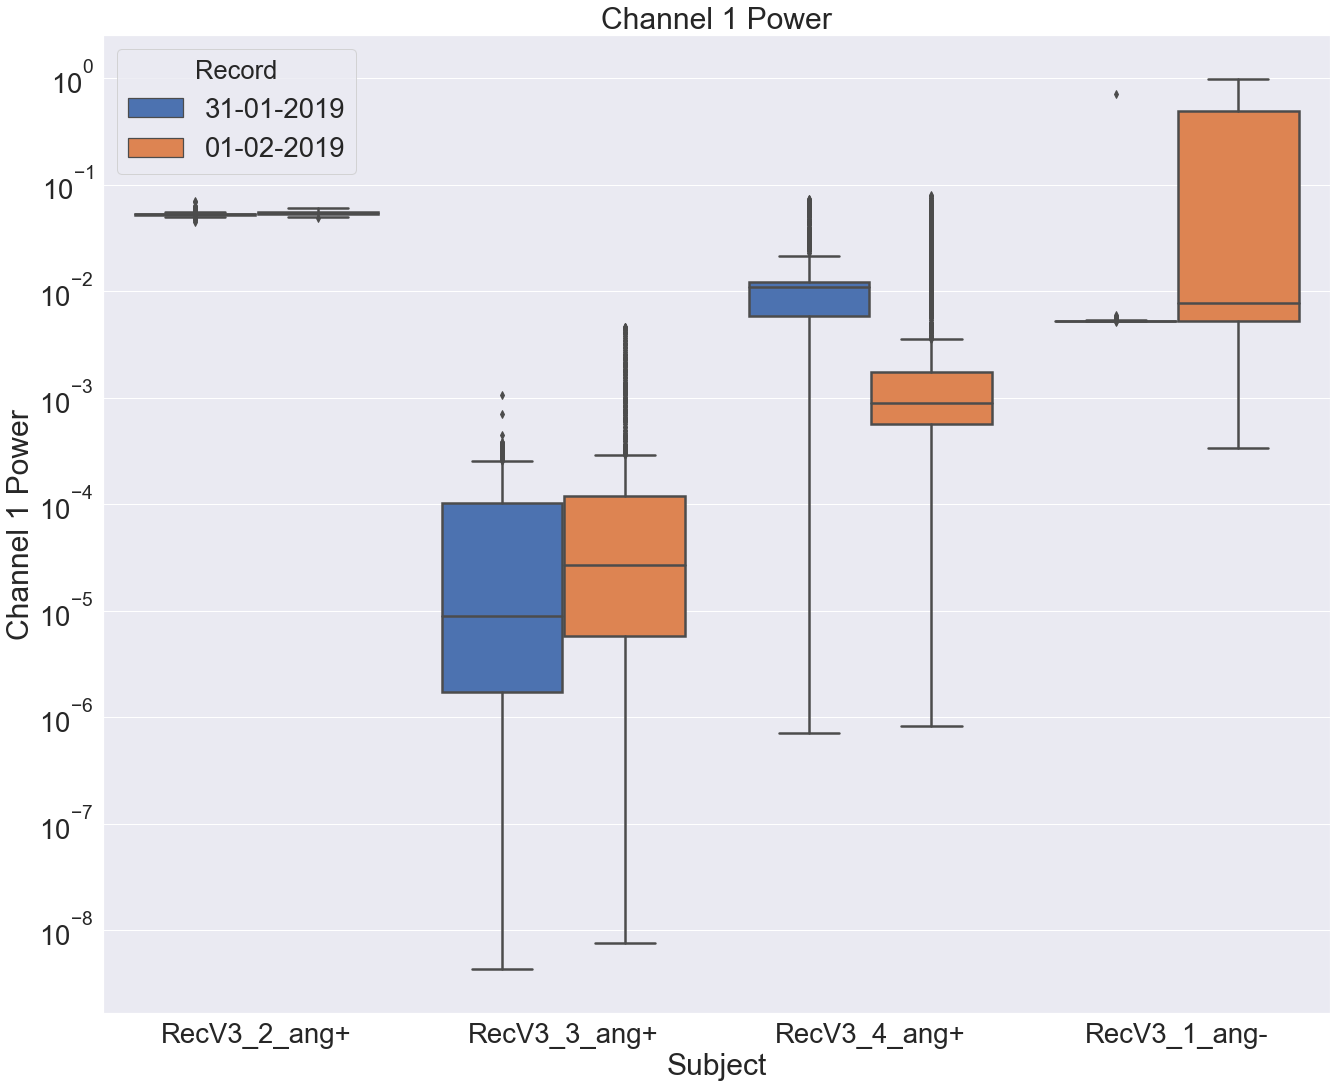

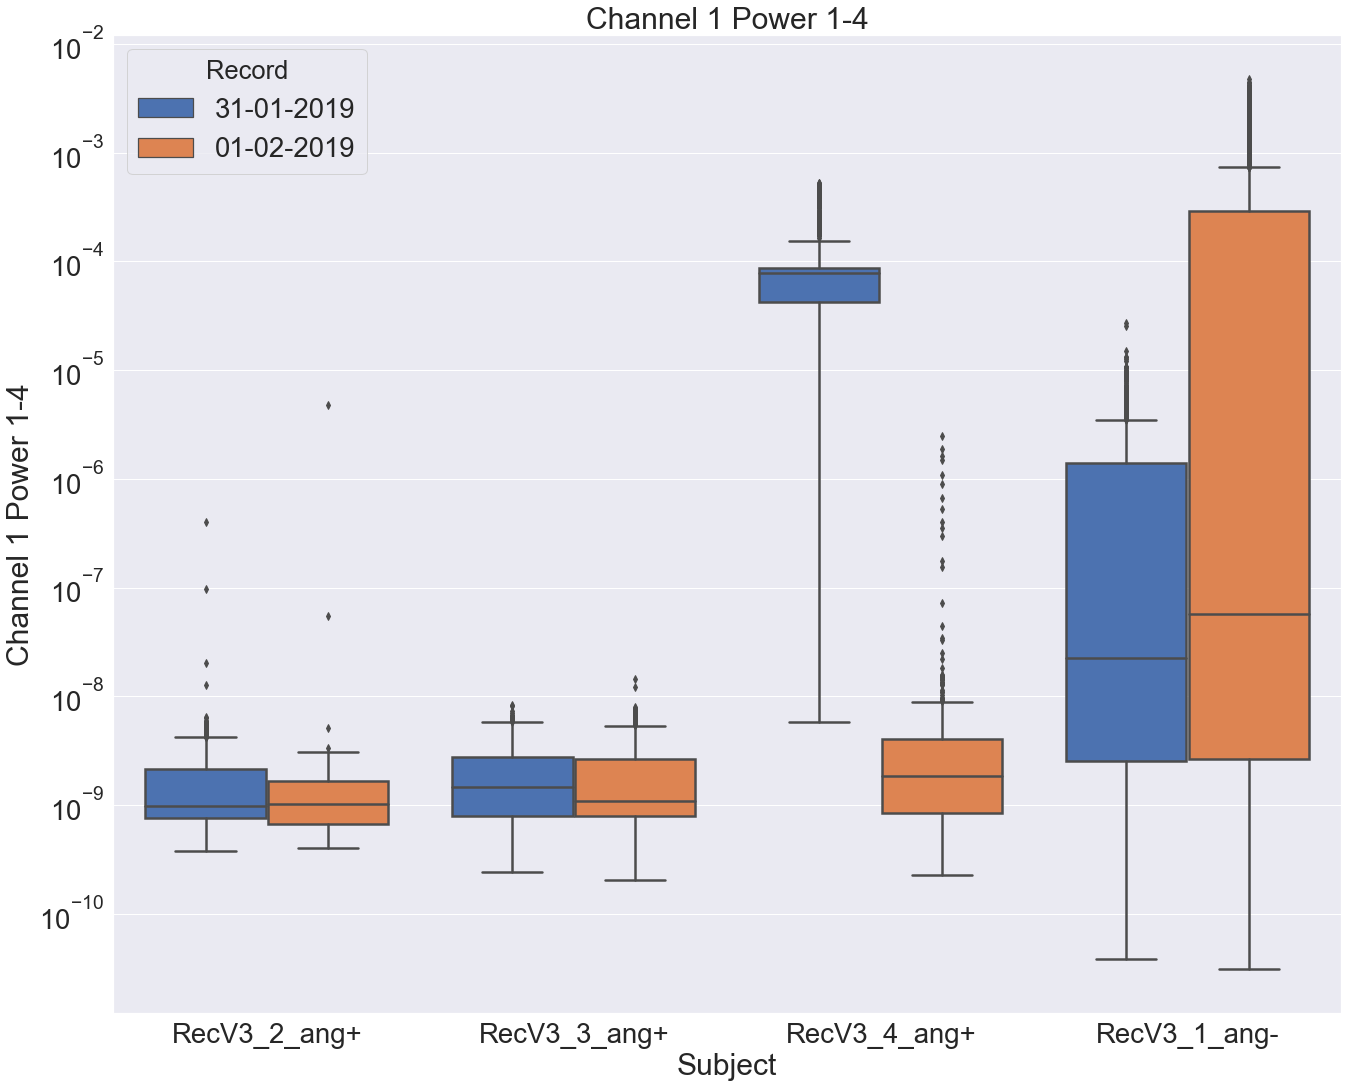

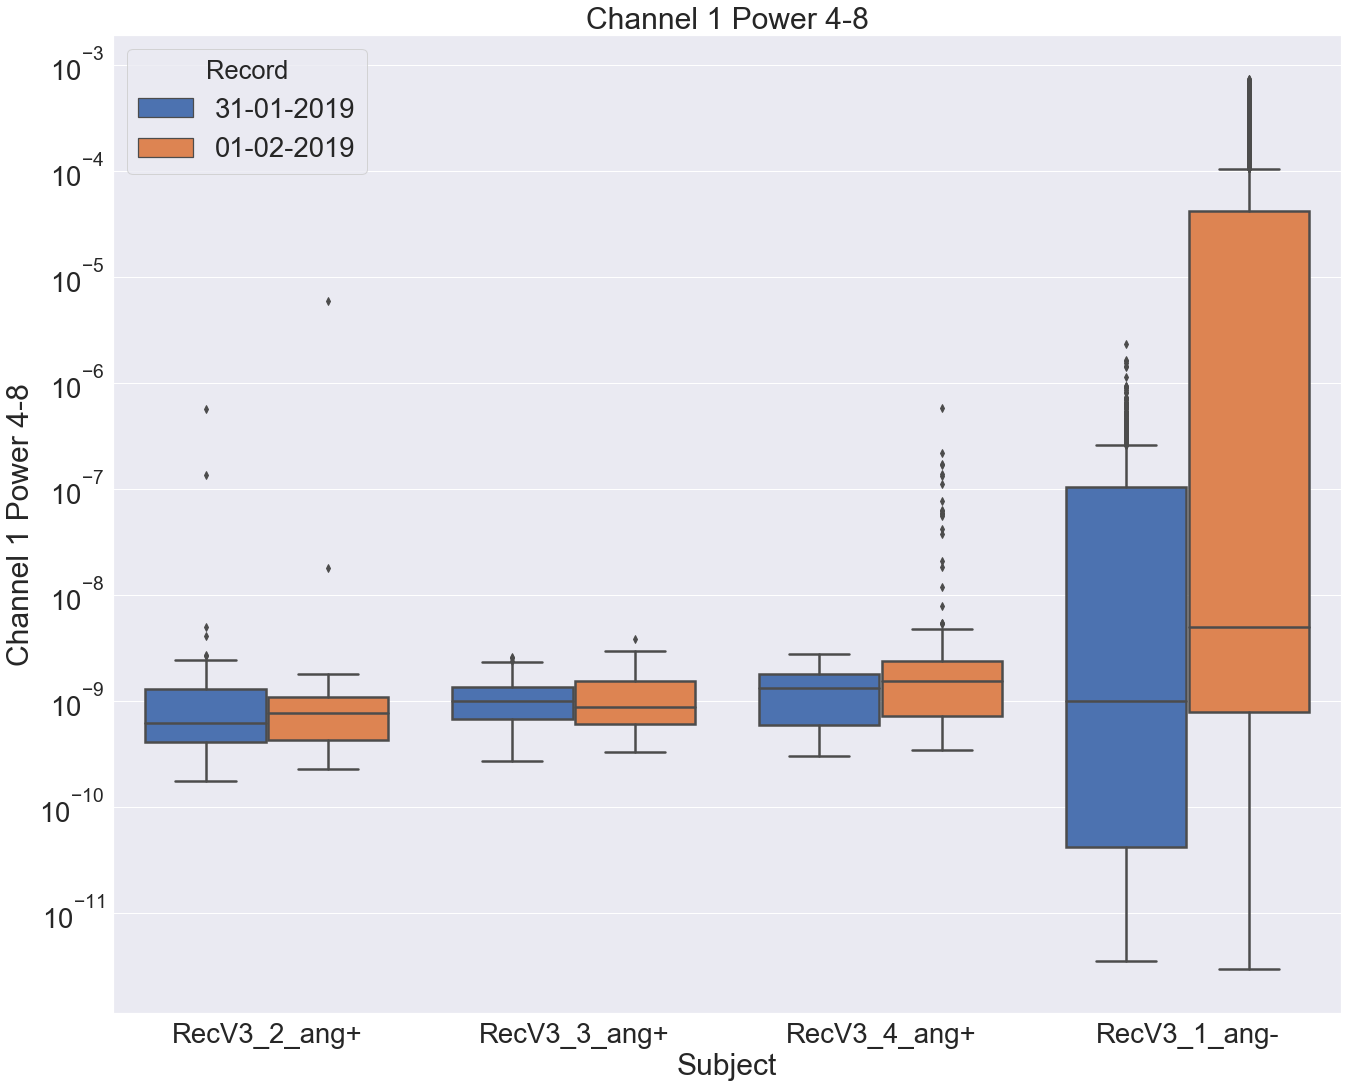

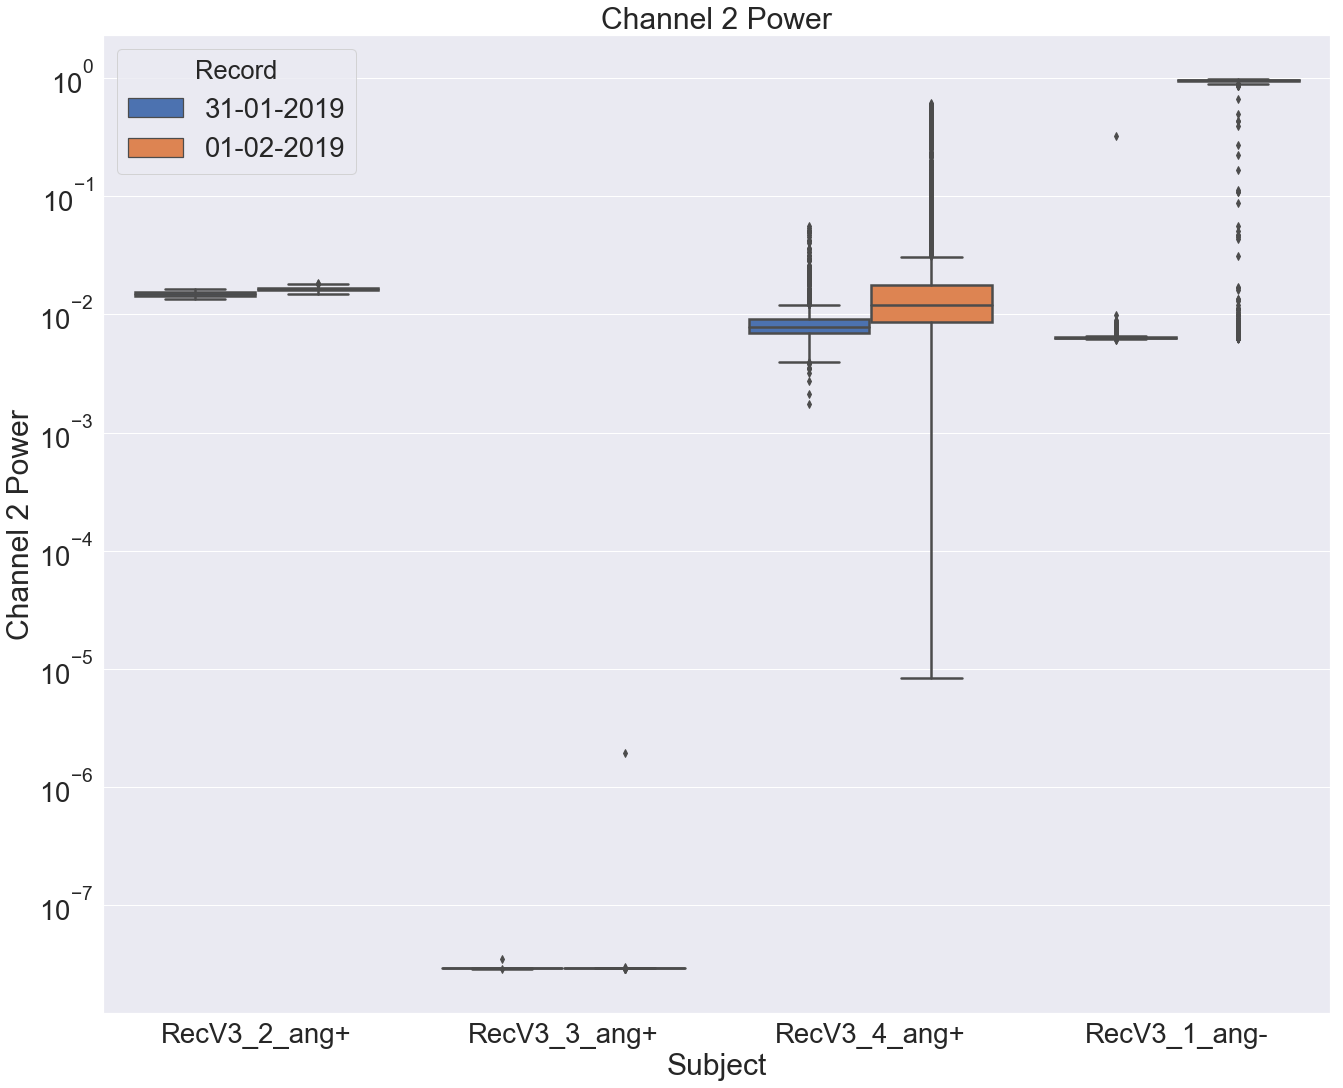

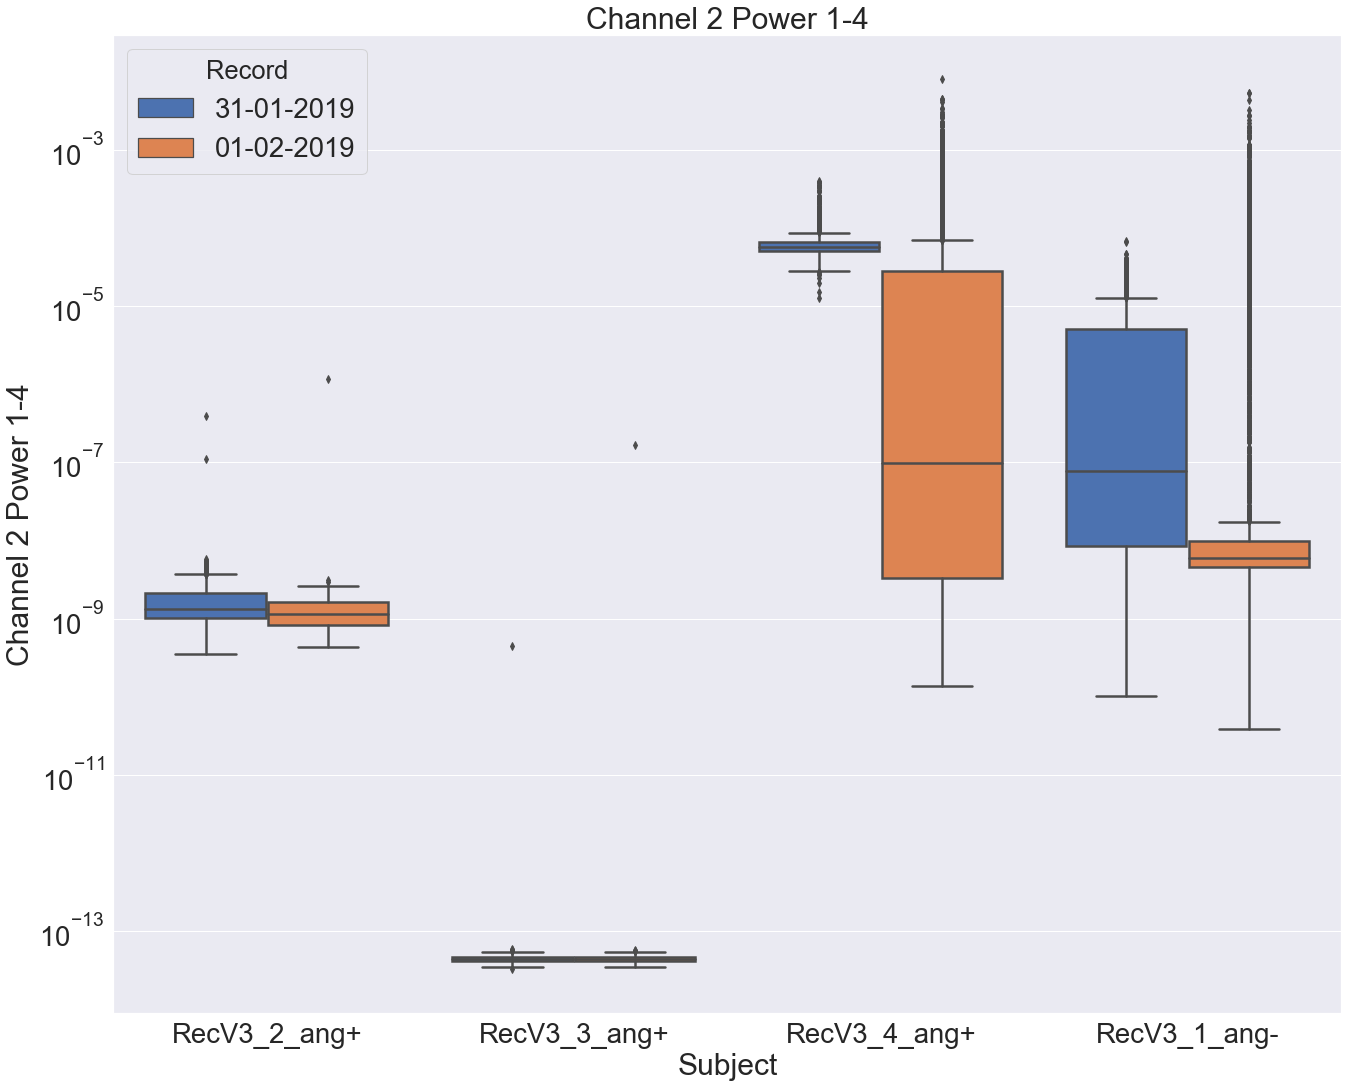

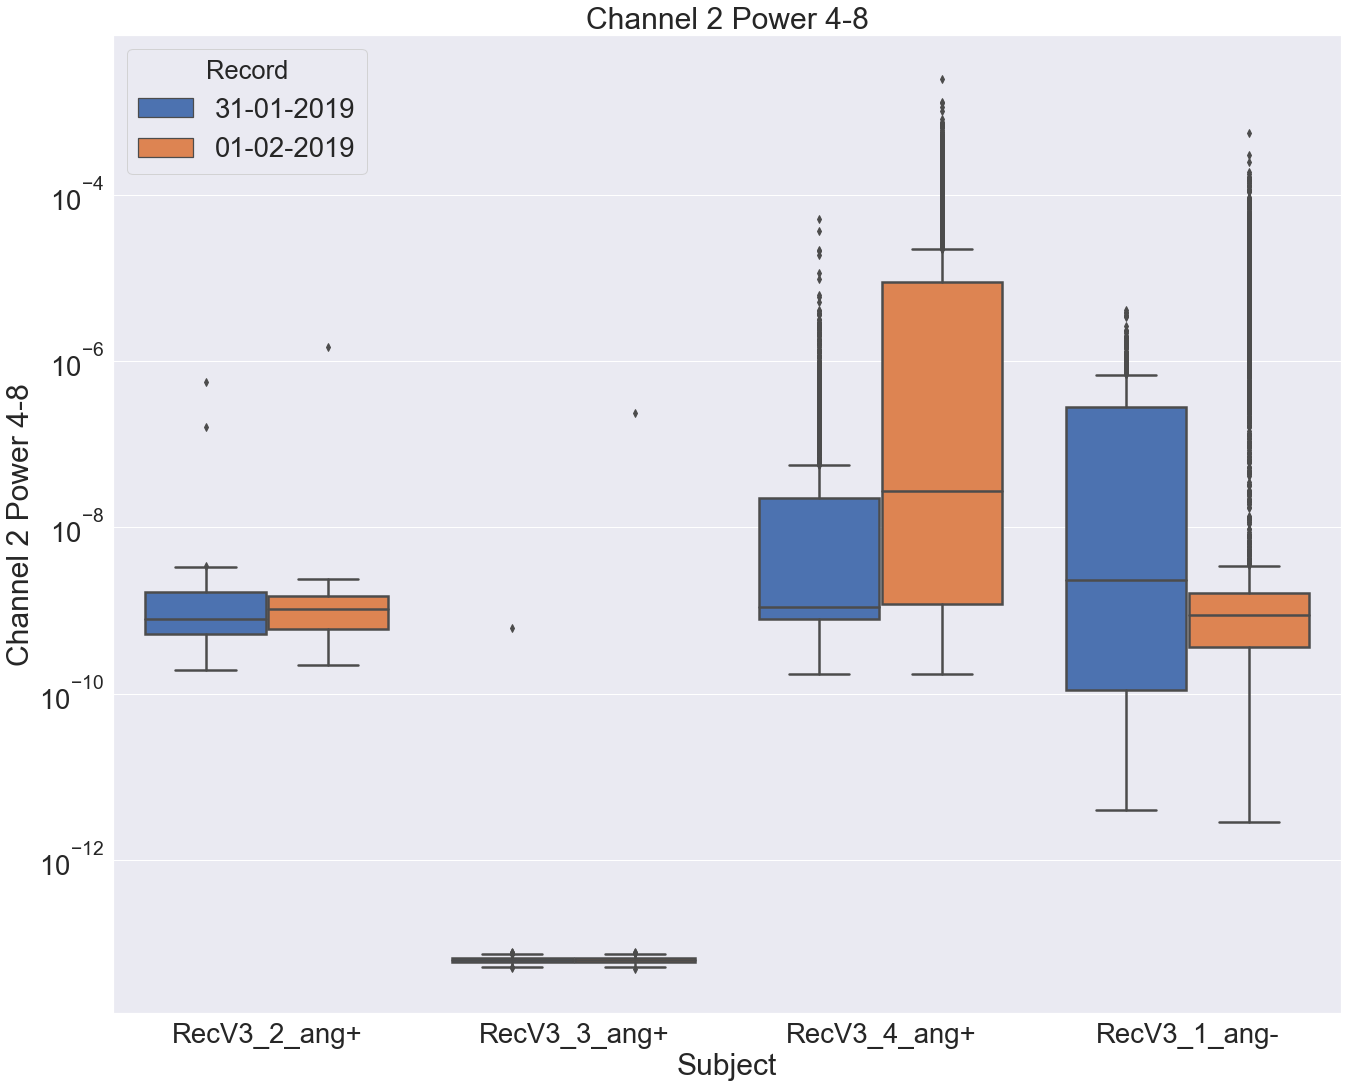

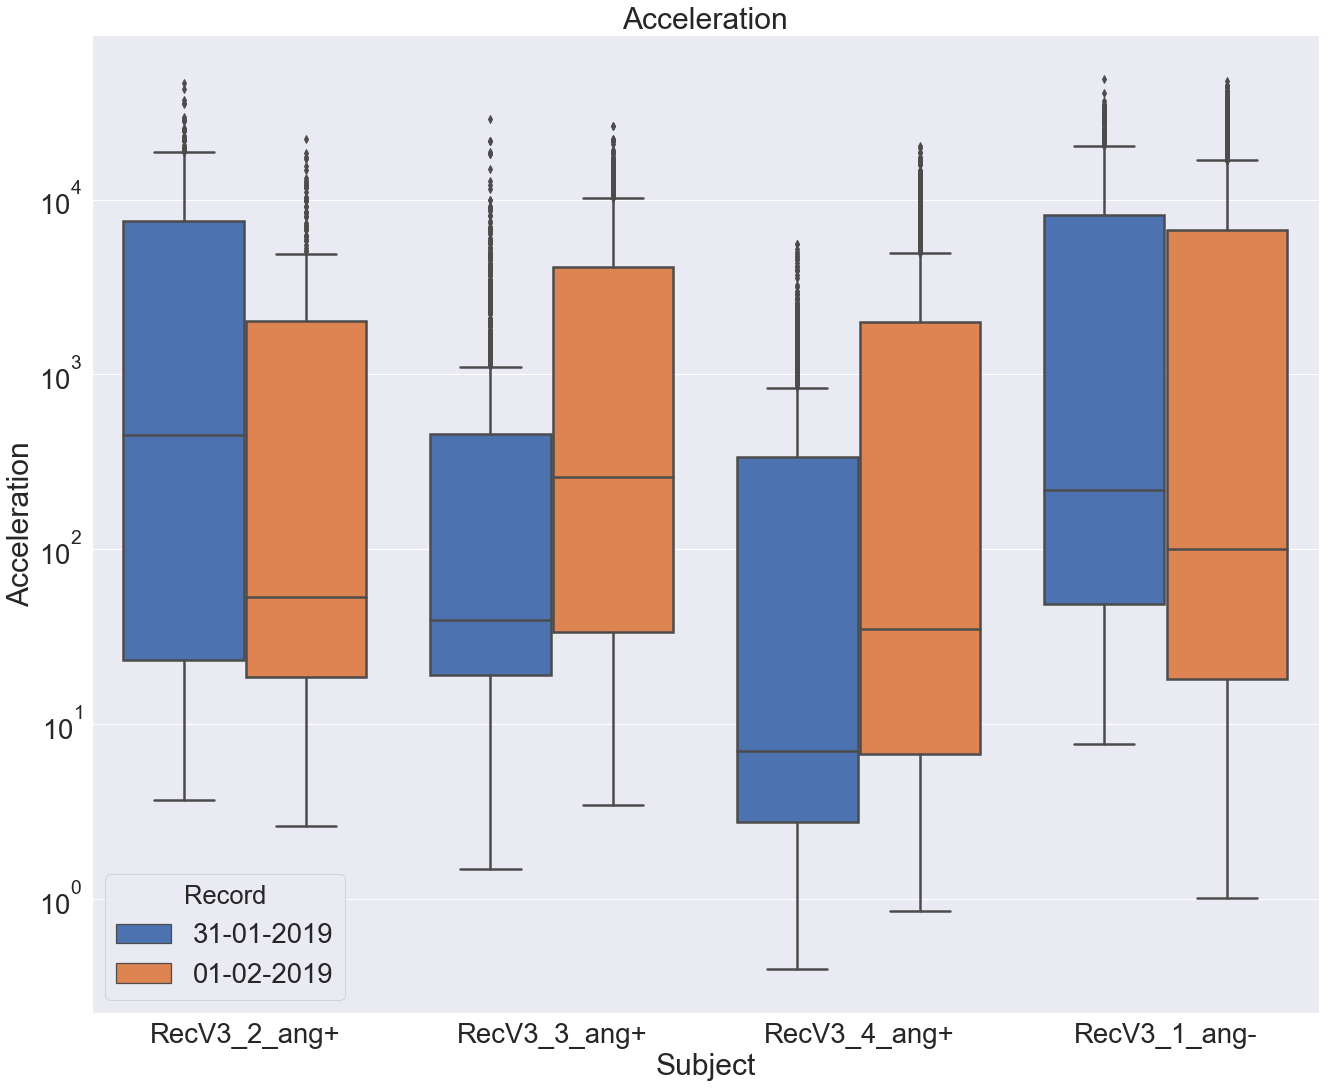

In [57]:
for name in data.columns[:-2]:

    f, ax = plt.subplots()
    ax.set(yscale="log")
    sns.boxplot(x="Subject", 
            y=name, 
            hue="Record",
            hue_order=['31-01-2019', '01-02-2019'],
            linewidth=2.5,
            saturation=1,
            data=data, 
            ax=ax)
    title(name)
    show()

In [12]:
power = pd.concat([
    data[data["Record"]==0].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==1].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==2].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==3].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==4].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==5].loc[:, "Channel 1 Power 4-8"],
    data[data["Record"]==6].loc[:, "Channel 2 Power 4-8"],
    data[data["Record"]==7].loc[:, "Channel 1 Power 4-8"]
])

new_df = pd.concat([power, data["Record"], data["Subject"]], axis=1)
new_df = new_df.rename(columns={0: "Power 4-8"})
new_df
#           names = ["Power 4-8", "Record"])
# data[data["Record"]==6]["Channel 1 Power 4-8"],
# data[data["Record"]==7]["Channel 1 Power 4-8"],

,Power 4-8,Record
0,3.730016e-10,0
1,3.547715e-10,0
2,3.687336e-10,0
3,8.932669e-10,0
4,1.035160e-09,0
5,9.917697e-10,0
6,2.317291e-09,0
7,1.014493e-09,0
8,9.377440e-10,0
9,1.086684e-09,0


NameError: name 'new_df' is not defined

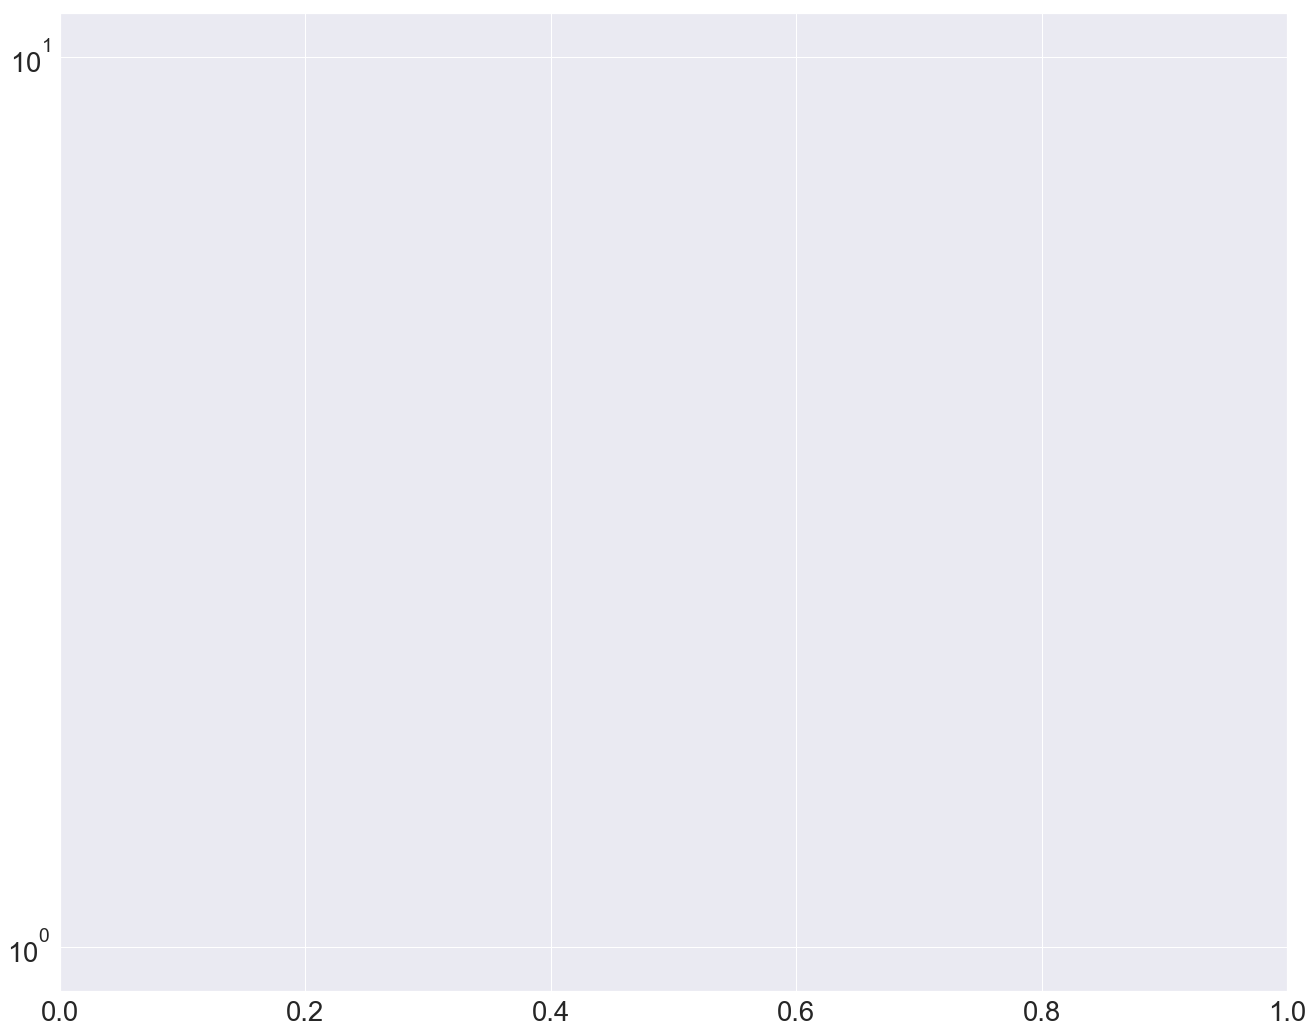

In [68]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="Record", y="Power 4-8", data=new_df, ax=ax)
title("Power 4-8")
show()

In [94]:
data["Subject+Record"] = data["Subject"] +" "+ data["Record"]

In [103]:
data

,Channel 1 Power,Channel 1 Power 1-4,Channel 1 Power 4-8,Channel 2 Power,Channel 2 Power 1-4,Channel 2 Power 4-8,Acceleration,Subject,Record,Subject+Record
0,0.052778,5.699744e-10,3.160907e-10,0.015787,7.367579e-10,5.668753e-10,1018.953600,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
1,0.053052,5.627204e-10,2.709586e-10,0.015732,7.498979e-10,4.421532e-10,249.270733,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
2,0.053176,6.521131e-10,4.365111e-10,0.015707,9.892243e-10,8.070392e-10,71.134133,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
3,0.052996,7.137406e-10,2.857428e-10,0.015643,1.072749e-09,4.327074e-10,58.265133,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
4,0.052461,4.965823e-10,3.505760e-10,0.015441,5.894226e-10,5.096781e-10,2431.412067,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
5,0.052397,6.400241e-10,4.100222e-10,0.015573,7.990883e-10,5.178795e-10,1077.991733,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
6,0.052448,7.147998e-10,3.276418e-10,0.015723,9.247423e-10,3.948650e-10,100.672333,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
7,0.052396,8.680174e-10,6.323382e-10,0.015658,1.113766e-09,9.107700e-10,97.968933,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
8,0.052122,7.147329e-10,3.058392e-10,0.015672,8.225040e-10,3.967438e-10,11872.065200,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019
9,0.052404,5.985720e-10,3.942953e-10,0.015808,8.155583e-10,4.993467e-10,8493.218800,RecV3_2_ang+,01-02-2019,RecV3_2_ang+ 01-02-2019


/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


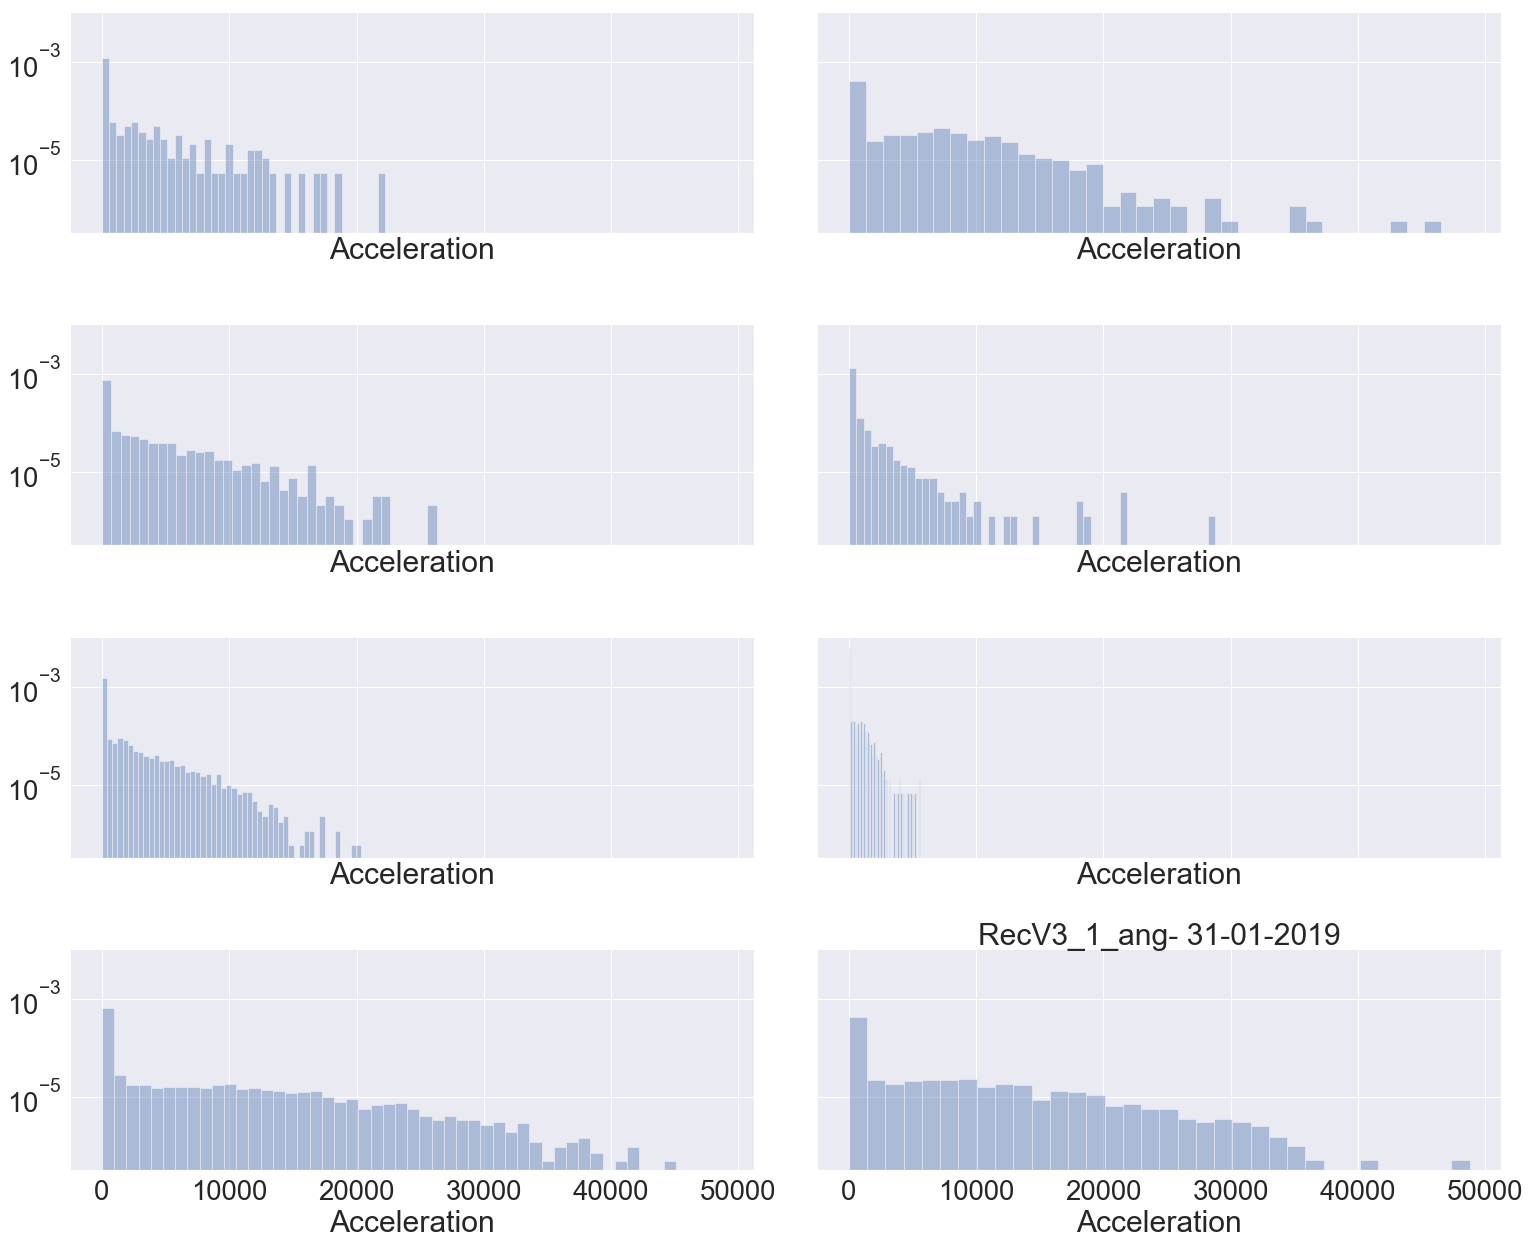

In [140]:
# Set up the matplotlib figure
f, axes = plt.subplots(4, 2, sharex=True, sharey=True)

sns.despine(left=True)

row = 0
column = 0 

for i, subject in enumerate(data["Subject+Record"].unique()):
    axes[row, column].set(yscale="log")
    sns.distplot(data[data["Subject+Record"]==subject]["Acceleration"],
#                  bins=100,
                 kde=False,
                 hist=True,
                 norm_hist=True,
                 ax=axes[row, column])
    title(subject)
    if column == 1:
        column = 0
        row += 1
    else: 
        column += 1

# plt.setp(axes, yticks=[])
plt.tight_layout()


/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


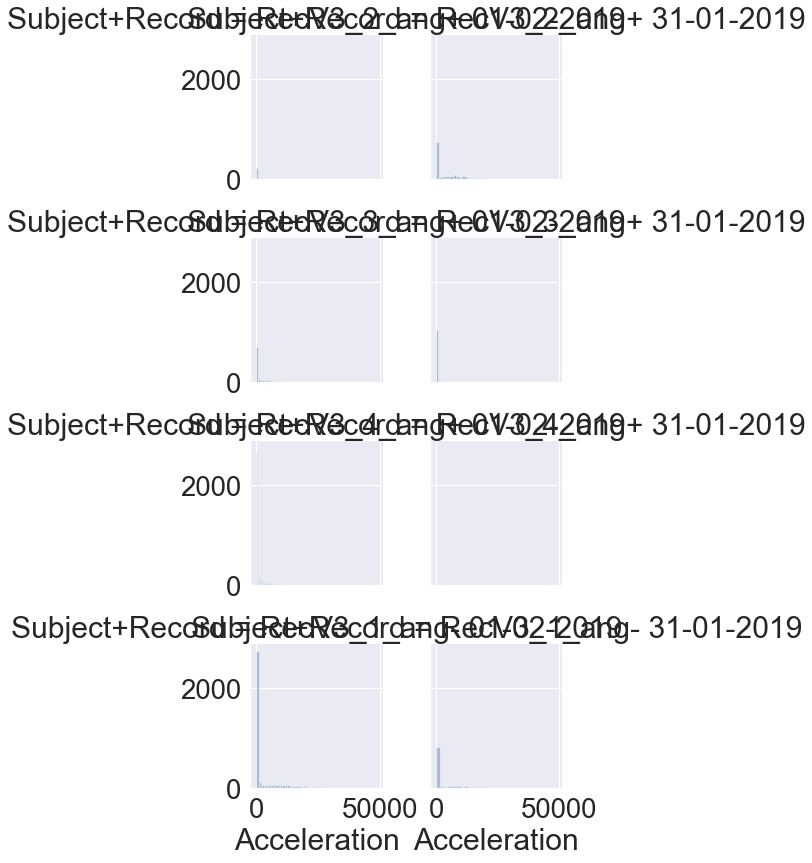

In [131]:
attend = sns.load_dataset("attention").query("subject <= 12")
g = sns.FacetGrid(data, col="Subject+Record", col_wrap=2)
g.map(sns.distplot, "Acceleration", kde=False);